# Part 1: EDA

Approach:

- Load and Prepare Data: Import the logins.json file and convert timestamps to a suitable datetime format.
- Data Aggregation: Aggregate login counts in 15-minute intervals.
- Visualization: Create time series plots to visualize login trends.
- Analysis: Identify patterns such as daily cycles, peak times, and seasonal variations.

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm

Number of Duplicate Records: 877


/var/folders/03/xhpkx5wj0vn6tgq603hfg5vr0000gn/T/ipykernel_17567/2683952991.py:8: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  login_counts=pd.DataFrame(logins_data['login_time'].value_counts().resample('15T').sum()).reset_index()


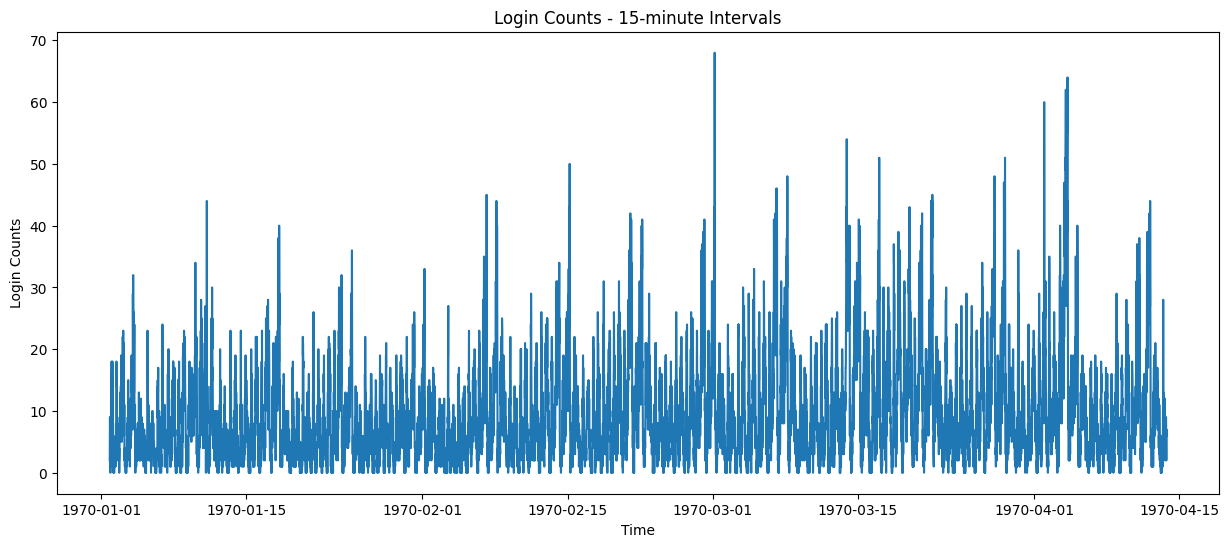

In [48]:
# Load data
logins_data = pd.read_json('./ultimate_challenge/logins.json')
logins_data['login_time'] = pd.to_datetime(logins_data['login_time'])

print('Number of Duplicate Records:',len(logins_data[logins_data.duplicated(keep='first')]))
logins_data=logins_data[~logins_data.duplicated(keep='first')]

login_counts=pd.DataFrame(logins_data['login_time'].value_counts().resample('15T').sum()).reset_index()
login_counts.columns=['login_time','login_count']

# Visualization
plt.figure(figsize=(15, 6))
plt.plot(login_counts.login_time, login_counts.login_count)
plt.title('Login Counts - 15-minute Intervals')
plt.xlabel('Time')
plt.ylabel('Login Counts')
plt.show()

From this visualization of login counts in 15-minute intervals, we can start to draw some initial observations about the demand patterns:

1. **Periodicity**: There appears to be a cyclical pattern suggesting a periodic increase and decrease in login counts. This could indicate daily cycles (e.g., higher demand during certain hours of the day) and weekly cycles (e.g., differences between weekdays and weekends).

2. **Peaks and Troughs**: The plot shows clear peaks and troughs. The peaks could correspond to busy periods when login activity is high, such as during rush hours, evenings, or special events. The troughs likely indicate off-peak times such as late night or early morning hours when fewer users are active.

3. **Trend Over Time**: While the cyclical pattern is evident, there does not appear to be a clear upward or downward trend over the time span of this data. This could imply that the demand is relatively stable over these months, without significant long-term increases or decreases.

4. **Anomalies**: There are some unusually high spikes in the data. These could be due to special events or could be anomalies that warrant further investigation.

5. **Data Quality Issues**: Without seeing any obvious gaps or inconsistencies in the plot, there do not appear to be major data quality issues at this level of analysis. However, a more detailed examination of the raw data would be necessary to confirm this.

In [53]:
login_counts.dtypes

login_time     datetime64[ns]
login_count             int64
dtype: object

In [51]:
# Check for missing values
missing_values = login_counts.isnull().sum()
print("Missing values in each column:\n", missing_values)

Missing values in each column:
 login_time     0
login_count    0
dtype: int64


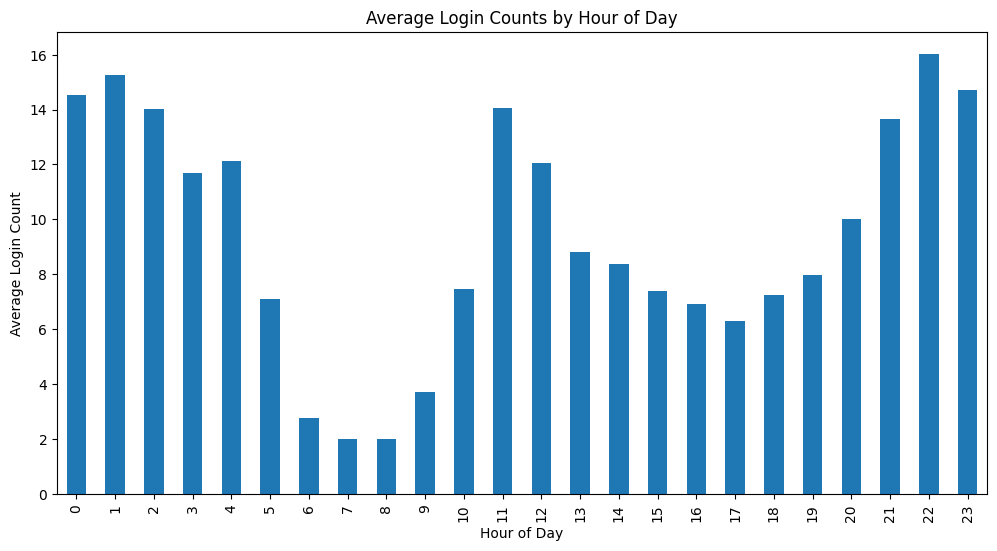

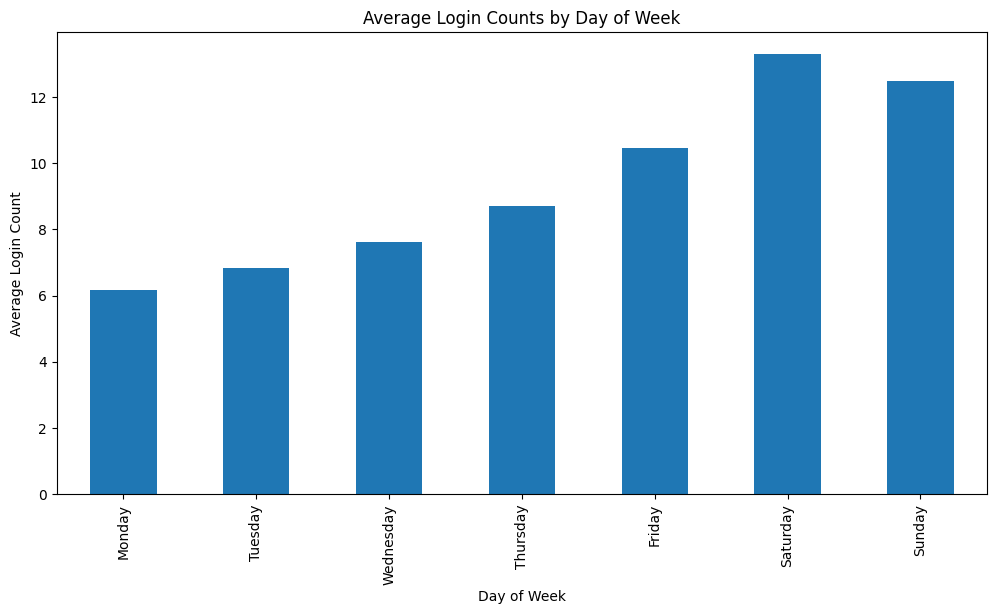

In [57]:
# Aggregate by hour and by day of the week for patterns
login_counts['hour'] = login_counts.login_time.dt.hour
login_counts['weekday'] = login_counts.login_time.dt.day_name()

# Mean counts by hour
hourly_avg = login_counts.groupby('hour')['login_count'].mean()

# Mean counts by day of the week, with proper ordering of days
weekday_avg = login_counts.groupby('weekday')['login_count'].mean().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)

# Plot hourly patterns
plt.figure(figsize=(12, 6))
hourly_avg.plot(kind='bar')
plt.title('Average Login Counts by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Login Count')
plt.show()

# Plot daily patterns
plt.figure(figsize=(12, 6))
weekday_avg.plot(kind='bar')
plt.title('Average Login Counts by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Login Count')
plt.show()

### Hour of Day Analysis:

From the first chart showing average login counts by the hour of the day, we notice:

- **Late Night to Early Morning Activity**: A significant spike in logins occurs after midnight, peaking around 1-2 AM. This could indicate a high demand for services during late-night hours, potentially due to nightlife activities.
- **Morning Lull**: There's a noticeable drop in activity starting around 5 AM, reaching the lowest point at 6 AM, which could correspond to the time when late-night demand drops off before the morning rush begins.
- **Evening Peak**: Another increase in logins is observed in the evening, starting to rise at 5 PM and peaking around 9 PM to 11 PM, which might be related to people traveling for evening engagements or returning home from work.

### Day of Week Analysis:

The second chart, which shows the average login counts by the day of the week, reveals:

- **Weekend Surge**: The average login count rises on Friday and reaches the highest on Saturday and Sunday, suggesting that the weekend is the busiest period, likely due to leisure activities or weekend outings.

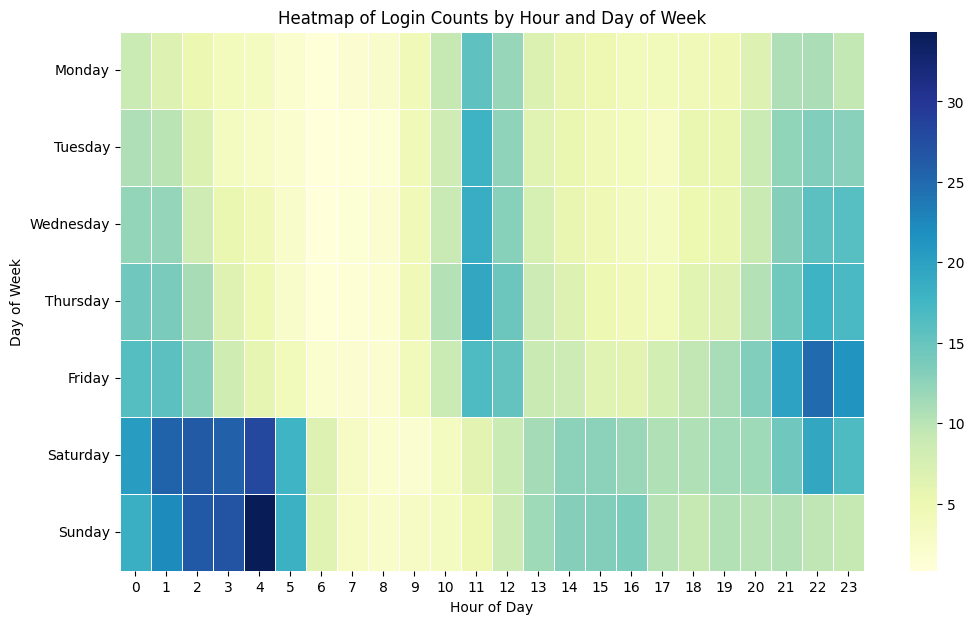

In [61]:
# Heatmap of login counts by hour and day
heatmap_data = login_counts.pivot_table(index=login_counts.login_time.dt.dayofweek, 
                                        columns=login_counts.login_time.dt.hour, 
                                        values='login_count', 
                                        aggfunc='mean').reindex(index=[0, 1, 2, 3, 4, 5, 6])

# Display the heatmap
plt.figure(figsize=(12, 7))
sns.heatmap(heatmap_data, cmap='YlGnBu', linewidths=.5)
plt.title('Heatmap of Login Counts by Hour and Day of Week')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.yticks(ticks=np.arange(0.5, len(heatmap_data.index), 1), 
           labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
           rotation=0)
plt.show()


### Heatmap Analysis:

The heatmap, which provides a combined view of the day of the week and hour of the day, allows us to pinpoint high-activity periods with more granularity:

- **Weekend Nights**: The darkest cells (indicating the highest login counts) on the heatmap are observed during late nights and early mornings on Saturday and Sunday, which aligns with the weekend surge noted earlier.
- **Weekday Evenings**: Weekday evenings, especially on Fridays, also show higher activity levels, reinforcing the observation from the hourly analysis.

These patterns suggest that strategies to meet demand could focus on allocating more resources during peak hours, especially on weekend nights and weekday evenings. The low-demand periods, such as early mornings on weekdays, could be used for vehicle maintenance or driver downtime.

/var/folders/03/xhpkx5wj0vn6tgq603hfg5vr0000gn/T/ipykernel_17567/1573089704.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  halfday_dec = sm.tsa.seasonal_decompose(login_counts['login_time'].value_counts().resample('12H').sum())


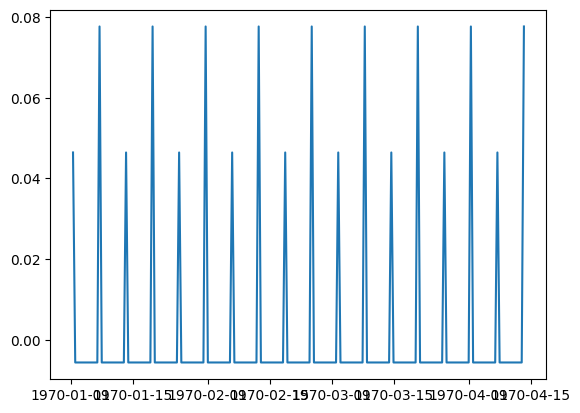

In [71]:
halfday_dec = sm.tsa.seasonal_decompose(login_counts['login_time'].value_counts().resample('12H').sum())
halfday_df=pd.DataFrame(halfday_dec.observed)
halfday_df.columns=['observed']
halfday_df['seasonal']=np.array(halfday_dec.seasonal)
halfday_df['trend']=np.array(halfday_dec.trend)
halfday_df['residual']=np.array(halfday_dec.resid)
halfday_df.reset_index(drop=False, inplace=True)

plt.plot(halfday_df['login_time'],halfday_df['seasonal'],label='observed')

/var/folders/03/xhpkx5wj0vn6tgq603hfg5vr0000gn/T/ipykernel_17567/2296267629.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  halfday_dec = sm.tsa.seasonal_decompose(login_counts['login_time'].value_counts().resample('24H').sum())


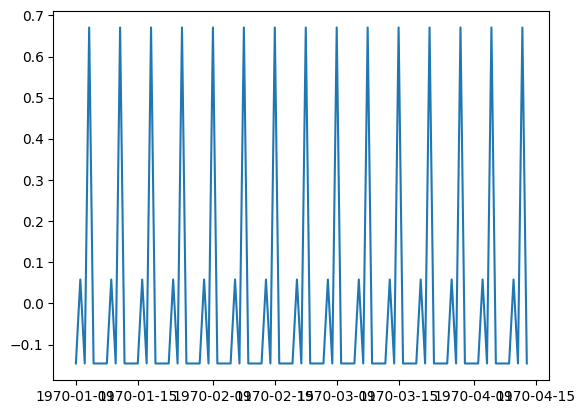

In [72]:
halfday_dec = sm.tsa.seasonal_decompose(login_counts['login_time'].value_counts().resample('24H').sum())
halfday_df=pd.DataFrame(halfday_dec.observed)
halfday_df.columns=['observed']
halfday_df['seasonal']=np.array(halfday_dec.seasonal)
halfday_df['trend']=np.array(halfday_dec.trend)
halfday_df['residual']=np.array(halfday_dec.resid)
halfday_df.reset_index(drop=False, inplace=True)

plt.plot(halfday_df['login_time'],halfday_df['seasonal'],label='observed')

# Part 2: Experiment and Metrics Design


### Key Measure of Success

The key measure of success would be the **increase in cross-city trips**—the number of trips that drivers make between Gotham and Metropolis. This metric directly captures the behavior the toll reimbursement program intends to influence. It's measurable, specific, and closely aligned with the ultimate goal of the experiment, which is to encourage drivers to serve both cities without the toll cost as a barrier.

### Experiment Design

#### a) Implementation of the Experiment

1. **Selection of Participants**: Randomly select a group of drivers from both cities who have a history of serving only one city. Ensure a large enough sample to detect the effect of toll reimbursement.
2. **Control and Treatment Groups**: Divide the drivers into two groups: one that will receive toll reimbursements (treatment group) and one that will not (control group).
3. **Duration**: Run the experiment for a sufficient period, possibly a few months, to account for variability in driver behavior and to allow patterns to emerge.
4. **Data Tracking**: Collect data on the number of cross-city trips made by drivers in both groups. Additionally, track other variables that could influence results, such as overall activity level, time of day, and day of the week.

#### b) Statistical Tests

1. **Before-and-After Analysis**: For each driver in the treatment group, compare the number of cross-city trips before and after the reimbursement policy is implemented.
2. **Between-Groups Analysis**: Use a two-sample t-test to compare the average change in cross-city trips between the control and treatment groups.
3. **Regression Analysis**: If there are confounding variables, a regression analysis might be appropriate to isolate the effect of toll reimbursement from other factors.

#### c) Interpretation and Recommendations

- **Significance Testing**: Determine if the observed difference in the number of cross-city trips between the two groups is statistically significant using p-values and the aforementioned t and z tests.
- **Effect Size**: Calculate the effect size to understand the practical significance of the experiment.
- **Confidence Intervals**: Provide confidence intervals for the estimated effect to convey the precision of the estimates.
- **Operational Recommendations**: If the experiment shows a significant increase in cross-city trips, recommend the continuation and possibly the expansion of the toll reimbursement policy. If the increase is not significant, further investigation is needed to understand why the policy did not work as expected.
- **Caveats**: Discuss any potential biases, like selection bias or attrition bias. Mention external factors that could have influenced the results, such as seasonal events or changes in demand.

# Part 3: Predictive modeling

In [147]:
ultimate_df = pd.read_json('./ultimate_challenge/ultimate_data_challenge.json')

In [148]:
ultimate_df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [149]:
ultimate_df['signup_date'] = pd.to_datetime(ultimate_df['signup_date'])
ultimate_df['last_trip_date'] = pd.to_datetime(ultimate_df['last_trip_date'])

In [150]:
ultimate_df.columns

Index(['city', 'trips_in_first_30_days', 'signup_date', 'avg_rating_of_driver',
       'avg_surge', 'last_trip_date', 'phone', 'surge_pct',
       'ultimate_black_user', 'weekday_pct', 'avg_dist',
       'avg_rating_by_driver'],
      dtype='object')

In [151]:
# Check for missing values
missing_values = ultimate_df.isnull().sum()
print(len(ultimate_df))
print("Missing values in each column:\n", missing_values)
# we don't want to drop nearly 20% of our data, so we will fill the missing values with some statistic

50000
Missing values in each column:
 city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64


In [152]:
rating_range = ultimate_df['avg_rating_of_driver'].dropna().describe()
print(rating_range)
# given the range of ratings, it makes sense to fill missing values with the median
ultimate_df['avg_rating_of_driver'] = ultimate_df['avg_rating_of_driver'].fillna(ultimate_df['avg_rating_of_driver'].median())

# Drop rows with missing values in 'phone' and 'avg_rating_by_driver'
ultimate_df.dropna(subset=['phone', 'avg_rating_by_driver'], inplace=True)

count    41878.000000
mean         4.601559
std          0.617338
min          1.000000
25%          4.300000
50%          4.900000
75%          5.000000
max          5.000000
Name: avg_rating_of_driver, dtype: float64


In [153]:
# Check for duplicates
duplicates = ultimate_df.duplicated().sum()
print("Number of duplicates:", duplicates)
ultimate_df.drop_duplicates(inplace=True)

Number of duplicates: 8


In [154]:
ultimate_df[['signup_date', 'last_trip_date']].describe()

,signup_date,last_trip_date
count,49398,49398
mean,2014-01-16 12:55:02.222762240,2014-04-19 15:05:48.499939328
min,2014-01-01 00:00:00,2014-01-01 00:00:00
25%,2014-01-09 00:00:00,2014-02-15 00:00:00
50%,2014-01-17 00:00:00,2014-05-08 00:00:00
75%,2014-01-24 00:00:00,2014-06-18 00:00:00
max,2014-01-31 00:00:00,2014-07-01 00:00:00


In [139]:
print(ultimate_df['city'].value_counts())
print(ultimate_df['phone'].value_counts())
print('First:',min(ultimate_df['signup_date']))
print('Last:',max(ultimate_df['last_trip_date']))

city
Winterfell        23019
Astapor           16352
King's Landing    10027
Name: count, dtype: int64
phone
iPhone     34442
Android    14956
Name: count, dtype: int64
First: 2014-01-01 00:00:00
Last: 2014-07-01 00:00:00


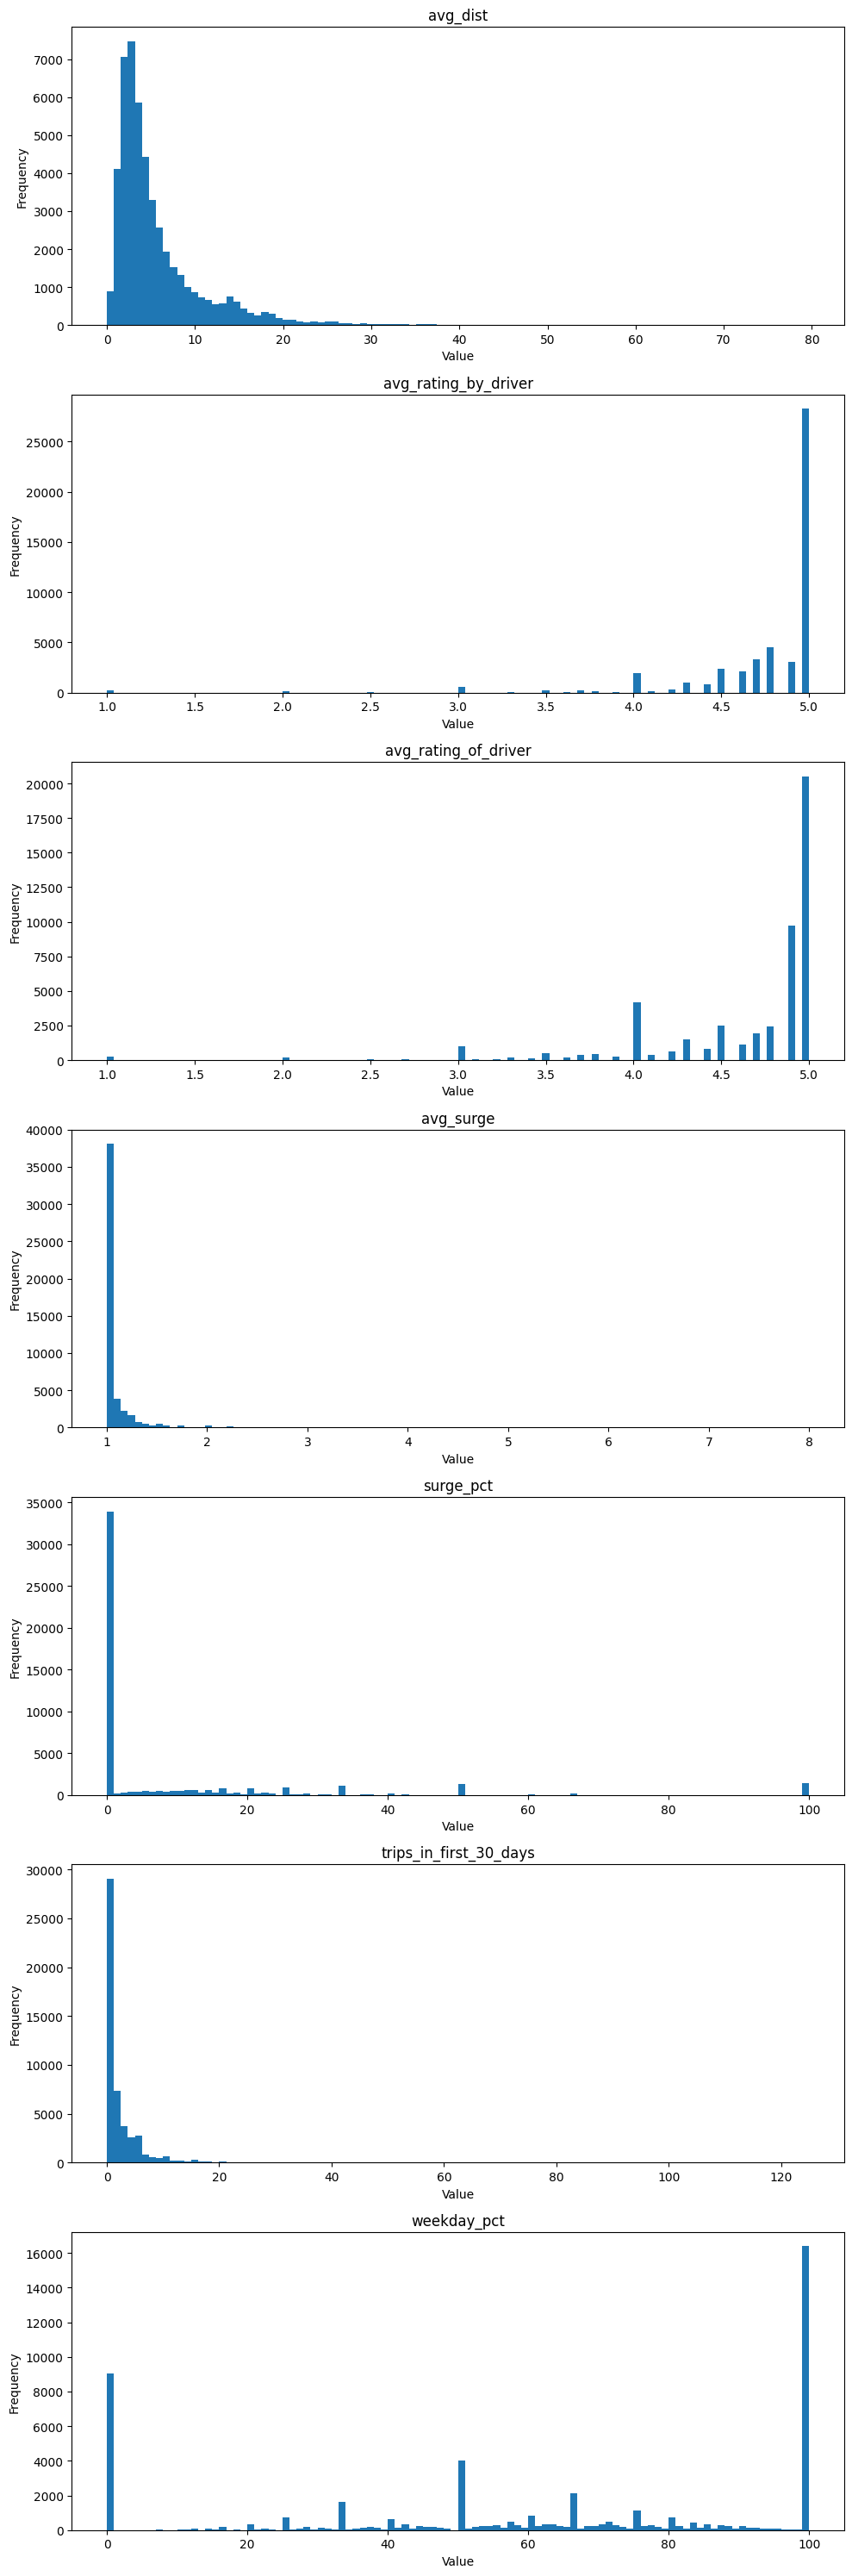

In [140]:
# List of column names
columns = ['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge', 'surge_pct', 'trips_in_first_30_days', 'weekday_pct']

# Create a figure and a set of subplots
fig, axs = plt.subplots(len(columns), 1, figsize=(10, 30))

# Create a histogram for each column
for i, column in enumerate(columns):
    axs[i].hist(ultimate_df[column], bins=100)
    axs[i].set_title(column)
    axs[i].set_xlabel("Value")
    axs[i].set_ylabel("Frequency")

# Display the plot
plt.tight_layout()
plt.show()

As we can see above, most of these fields do not follow a bell curve! Let us take a look for outliers!

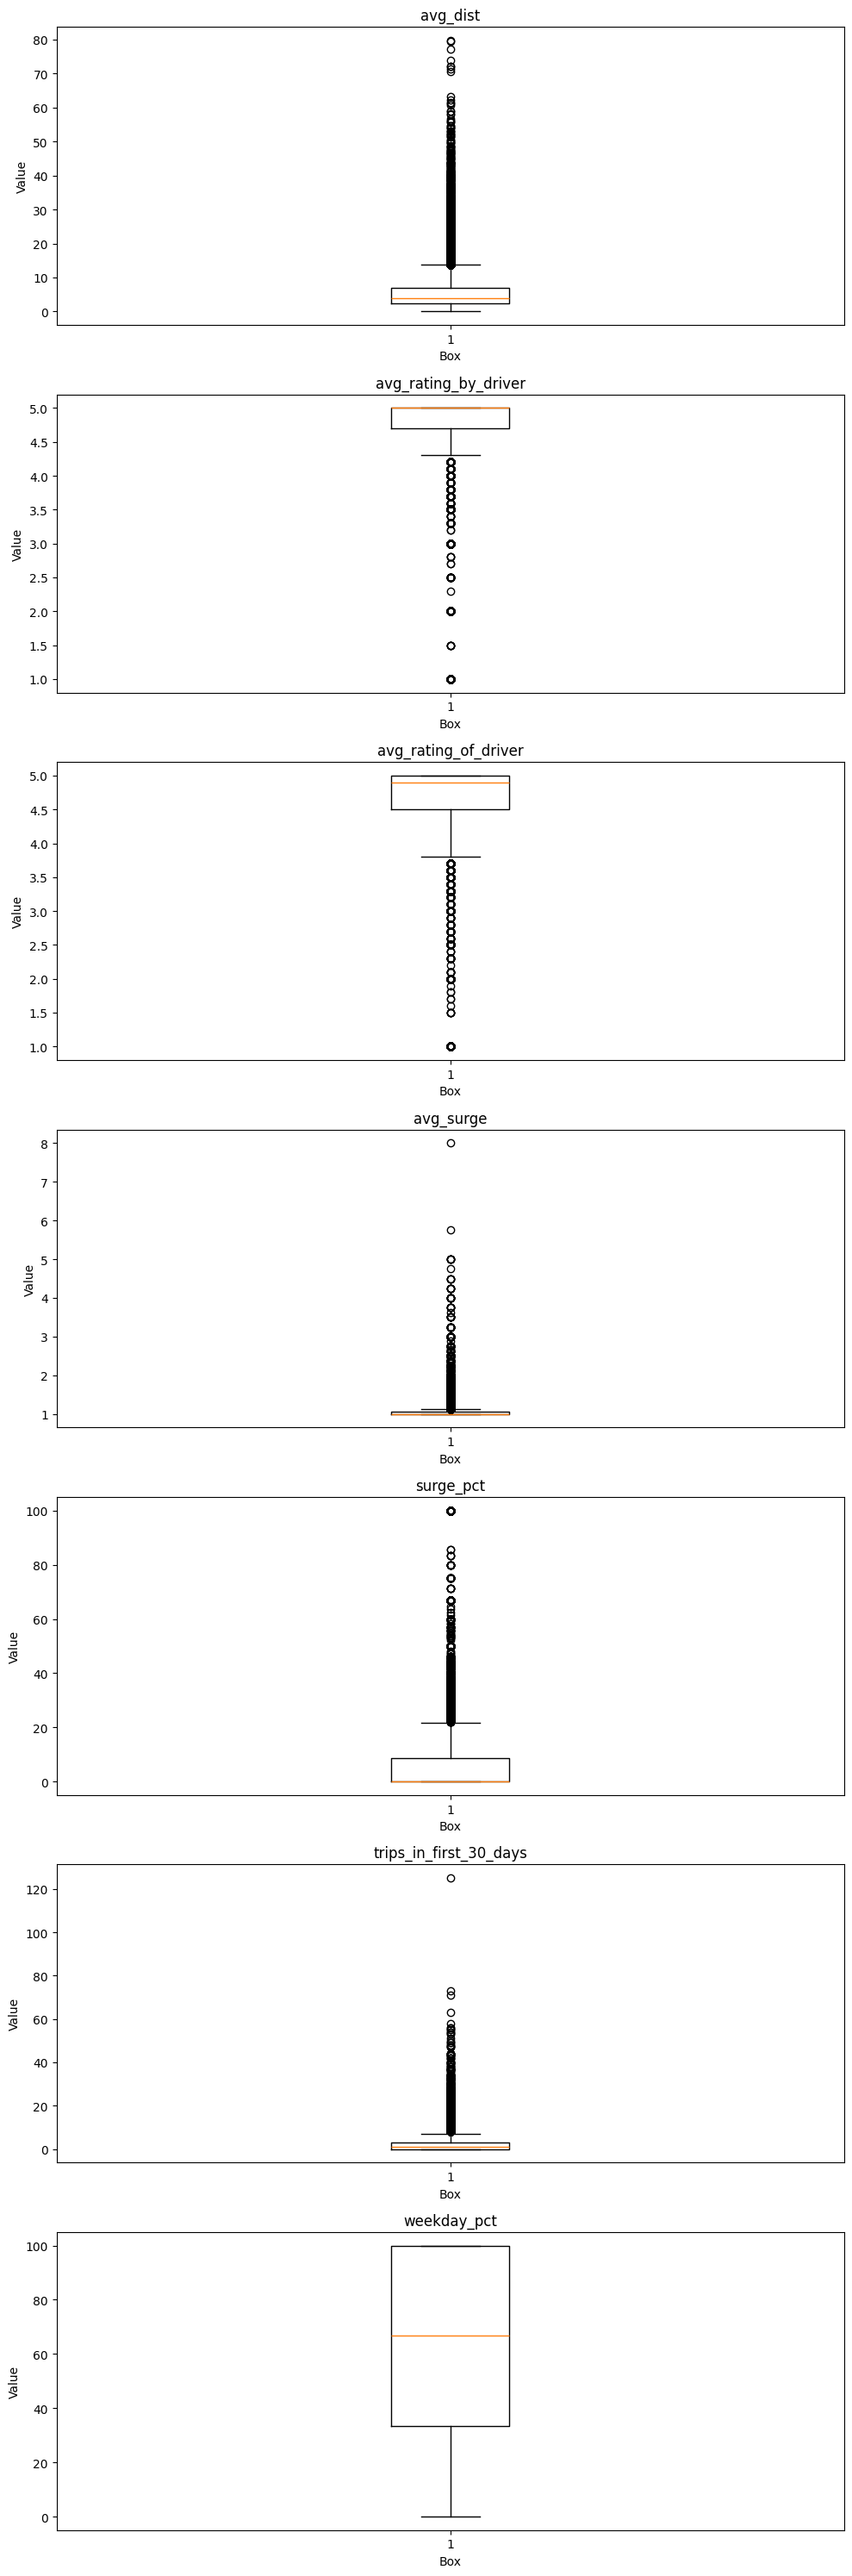

In [141]:
# List of column names
columns = ['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge', 'surge_pct', 'trips_in_first_30_days', 'weekday_pct']

# Create a figure and a set of subplots
fig, axs = plt.subplots(len(columns), 1, figsize=(10, 30))

# Create a box plot for each column
for i, column in enumerate(columns):
    axs[i].boxplot(ultimate_df[column])
    axs[i].set_title(column)
    axs[i].set_xlabel("Box")
    axs[i].set_ylabel("Value")

# Display the plot
plt.tight_layout()
plt.show()

In [155]:
def remove_outliers(arr):
    upperbound=np.array(arr).mean()+3*np.array(arr).std()
    lowerbound=np.array(arr).mean()-3*np.array(arr).std()
    bounds=np.append(np.array(arr)[np.array(arr)>upperbound],np.array(arr)[np.array(arr)<lowerbound])
    return np.array(list(set(arr)^set(bounds)))

In [156]:
ultimate_df=ultimate_df[ultimate_df['avg_dist'].isin(remove_outliers(ultimate_df['avg_dist']))]
ultimate_df=ultimate_df[ultimate_df['surge_pct'].isin(remove_outliers(ultimate_df['surge_pct']))]
ultimate_df=ultimate_df[ultimate_df['trips_in_first_30_days'].isin(remove_outliers(ultimate_df['trips_in_first_30_days']))]
print('After dropping outliers more than 3 stds approx.',len(ultimate_df),'is left of the original 50000, which is,',(len(ultimate_df)/50000)*100,'percent of the original data.')
ultimate_df.head()

After dropping outliers more than 3 stds approx. 45946 is left of the original 50000, which is, 91.892 percent of the original data.


,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
5,Winterfell,2,2014-01-09,3.5,1.00,2014-06-06,iPhone,0.0,True,100.0,10.56,5.0


In [157]:
# Assuming enroll_window_begin and enroll_window_end are the start and end of January 2014
# Assuming terminate_window_begin and terminate_window_end are the start and end of June 2014

enroll_window_begin = pd.Timestamp('2014-01-01')
enroll_window_end = pd.Timestamp('2014-01-31')
terminate_window_begin = pd.Timestamp('2014-06-01')
terminate_window_end = pd.Timestamp('2014-06-30')

# Existing code for calculating days_in_system and recency
ultimate_df['days_in_system'] = (ultimate_df['last_trip_date'] - ultimate_df['signup_date']).dt.days
ultimate_df['recency'] = (ultimate_df['last_trip_date'].max() - ultimate_df['last_trip_date']).dt.days

# Initialize columns
ultimate_df['enroll_window'] = 0
ultimate_df['terminate_window'] = 0
ultimate_df['active'] = 0

# Set enroll_window and terminate_window
ultimate_df.loc[(ultimate_df['signup_date'] >= enroll_window_begin) & (ultimate_df['signup_date'] <= enroll_window_end), 'enroll_window'] = 1
ultimate_df.loc[(ultimate_df['last_trip_date'] >= terminate_window_begin) & (ultimate_df['last_trip_date'] <= terminate_window_end), 'terminate_window'] = 1

# Set active
ultimate_df.loc[
    (ultimate_df['enroll_window'] == 1) & 
    (ultimate_df['terminate_window'] == 1) & 
    (ultimate_df['recency'] < 31) &
    (ultimate_df['trips_in_first_30_days'] > 0), 'active'] = 1

print('Fraction of active:', ultimate_df['active'].sum()/len(ultimate_df))

Fraction of active: 0.25760675575675795


In [158]:
ultimate_df.drop(['signup_date', 'last_trip_date'], axis=1, inplace=True)
ultimate_df.head()

,city,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,days_in_system,recency,enroll_window,terminate_window,active
0,King's Landing,4,4.7,1.10,iPhone,15.4,True,46.2,3.67,5.0,143,14,1,1,1
1,Astapor,0,5.0,1.00,Android,0.0,False,50.0,8.26,5.0,96,57,1,0,0
2,Astapor,3,4.3,1.00,iPhone,0.0,False,100.0,0.77,5.0,1,175,1,0,0
3,King's Landing,9,4.6,1.14,iPhone,20.0,True,80.0,2.36,4.9,170,2,1,1,1
5,Winterfell,2,3.5,1.00,iPhone,0.0,True,100.0,10.56,5.0,148,25,1,1,1


## Model Building

In [182]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [159]:
most_common_outcome = ultimate_df['active'].mode()[0]

# Predict the most common outcome for all users
ultimate_df['predicted_active'] = most_common_outcome

# Calculate the accuracy of the mean-based model
accuracy = (ultimate_df['predicted_active'] == ultimate_df['active']).mean()
print(f'Mean-Based Model Accuracy: {accuracy}')
ultimate_df.drop(['predicted_active'], axis=1, inplace=True)

Mean-Based Model Accuracy: 0.742393244243242


Considering the imbalance hinted by the mean-based model accuracy, ROC-AUC, along with Precision, Recall, and F1 Score, might be more appropriate than just accuracy.

In [162]:
print(ultimate_df.head())

             city  trips_in_first_30_days  avg_rating_of_driver  avg_surge  \
0  King's Landing                       4                   4.7       1.10   
1         Astapor                       0                   5.0       1.00   
2         Astapor                       3                   4.3       1.00   
3  King's Landing                       9                   4.6       1.14   
5      Winterfell                       2                   3.5       1.00   

     phone  surge_pct  ultimate_black_user  weekday_pct  avg_dist  \
0   iPhone       15.4                 True         46.2      3.67   
1  Android        0.0                False         50.0      8.26   
2   iPhone        0.0                False        100.0      0.77   
3   iPhone       20.0                 True         80.0      2.36   
5   iPhone        0.0                 True        100.0     10.56   

   avg_rating_by_driver  days_in_system  recency  enroll_window  \
0                   5.0             143       14 

In [200]:
# Separate features and target variable, also dropping the columns that went into calculating the target variable
X = ultimate_df.drop(['recency', 'enroll_window', 'terminate_window', 'active'], axis=1)
y = ultimate_df['active']

# Identifying numerical and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Creating a transformer for numerical and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ])

# Apply the transformations
X_processed = preprocessor.fit_transform(X)

# Extracting new feature names
new_categorical_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
all_features = numeric_features.to_list() + new_categorical_features.tolist()

# Converting the processed features back into a DataFrame
X_processed = pd.DataFrame(X_processed)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2)

In [201]:
# Fitting the logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predicting on the test set
y_pred = model.predict(X_test)

# Evaluating the model
print(classification_report(y_test, y_pred))
log_reg_importance = pd.DataFrame({'Feature': all_features, 'Importance': model.coef_[0]})

              precision    recall  f1-score   support

           0       0.93      0.93      0.93      6913
           1       0.79      0.79      0.79      2277

    accuracy                           0.89      9190
   macro avg       0.86      0.86      0.86      9190
weighted avg       0.89      0.89      0.89      9190



In [202]:
cv_scores = cross_val_score(model, X_processed, y, cv=5)
print("Cross-validation scores:", cv_scores)
print("Mean CV score:", cv_scores.mean())

Cross-validation scores: [0.88900979 0.89454783 0.89422135 0.89454783 0.89585374]
Mean CV score: 0.8936361081773152


In [203]:
rf = RandomForestClassifier()

# Fit the model to the training data
rf.fit(X_train, y_train)

# Predicting on the test set
y_pred_rf = rf.predict(X_test)

# Evaluating the rf
print(classification_report(y_test, y_pred_rf))
rf_importance = pd.DataFrame({'Feature': all_features, 'Importance': rf.feature_importances_})

cv_rf = cross_val_score(rf, X_processed, y, cv=5)
print("Cross-validation scores:", cv_rf)
print("Mean CV score:", cv_rf.mean())

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      6913
           1       0.91      0.96      0.94      2277

    accuracy                           0.97      9190
   macro avg       0.95      0.97      0.96      9190
weighted avg       0.97      0.97      0.97      9190

Cross-validation scores: [0.96605005 0.96811405 0.96746109 0.96909348 0.96648166]
Mean CV score: 0.967440068559051


In [204]:
gbm = GradientBoostingClassifier()

# Fit the model to the training data
gbm.fit(X_train, y_train)

# Predicting on the test set
y_pred_gbm = gbm.predict(X_test)

# Evaluating the gbm
print(classification_report(y_test, y_pred_gbm))
gbm_importance = pd.DataFrame({'Feature': all_features, 'Importance': gbm.feature_importances_})

cv_gbm = cross_val_score(gbm, X_processed, y, cv=5)
print("Cross-validation scores:", cv_gbm)
print("Mean CV score:", cv_gbm.mean())

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      6913
           1       0.91      0.97      0.94      2277

    accuracy                           0.97      9190
   macro avg       0.95      0.97      0.96      9190
weighted avg       0.97      0.97      0.97      9190

Cross-validation scores: [0.96702938 0.97050822 0.96811405 0.96811405 0.96680814]
Mean CV score: 0.9681147670175262


In [205]:
# Display feature importances
print("Logistic Regression Feature Importances:\n", log_reg_importance.sort_values(by='Importance', ascending=False))
print("\nRandom Forest Feature Importances:\n", rf_importance.sort_values(by='Importance', ascending=False))
print("\nGBM Feature Importances:\n", gbm_importance.sort_values(by='Importance', ascending=False))

Logistic Regression Feature Importances:
                    Feature  Importance
7           days_in_system    4.731092
0   trips_in_first_30_days    1.411239
10            phone_iPhone    0.364720
8      city_King's Landing    0.290764
9          city_Winterfell    0.087713
3                surge_pct    0.038752
5                 avg_dist    0.023046
2                avg_surge    0.012595
6     avg_rating_by_driver   -0.045912
1     avg_rating_of_driver   -0.073315
4              weekday_pct   -0.086107

Random Forest Feature Importances:
                    Feature  Importance
7           days_in_system    0.492542
0   trips_in_first_30_days    0.280663
6     avg_rating_by_driver    0.047767
4              weekday_pct    0.043854
3                surge_pct    0.038465
5                 avg_dist    0.031041
2                avg_surge    0.025025
1     avg_rating_of_driver    0.018300
10            phone_iPhone    0.009541
8      city_King's Landing    0.009144
9          city_Winterfe

Choosing Logistic Regression for this analysis was based on several factors:

### Why Logistic Regression?

1. **Binary Outcome**: Logistic regression is a go-to method for binary classification problems. Since the target variable 'active' is binary (active or not active), logistic regression is a suitable choice.

2. **Interpretability**: Logistic regression models are highly interpretable, providing valuable insights into how different predictors influence the probability of being active. 

3. **Baseline Model**: It's a good practice to start with a simple model and then move to more complex models if needed. Logistic regression serves as an excellent baseline model.

### Alternatives Considered

1. **Random Forest**: This is a robust and widely used classification algorithm that can handle a mix of numerical and categorical features and can capture complex nonlinear relationships.

2. **Gradient Boosting Machines (GBM)**: Algorithms like XGBoost, LightGBM, or CatBoost can often achieve higher performance than logistic regression, particularly with large and complex datasets.

These are more complex ensemble methods. They often provide better predictive accuracy but at the cost of reduced interpretability. Understanding how individual features affect the outcome is less straightforward.

### Concerns

1. **Feature Correlation**: Logistic regression assumes that predictors are independent of each other. If there's multicollinearity in the data, it can affect the model performance and interpretability.

2. **Data Imbalance**: If the dataset is imbalanced (uneven distribution of active and inactive users), it can bias the model towards the majority class.

3. **Model Complexity**: Logistic regression may not capture more complex relationships as effectively as some other algorithms.

4. **Overfitting and Underfitting**: Ensuring the model is neither overfitting nor underfitting is crucial. Regularization techniques can help in avoiding overfitting.

### Validity and Performance Indicators

1. **Accuracy**: A primary measure, but not always reliable, especially with imbalanced classes.

2. **Precision and Recall**: Important when dealing with imbalanced datasets. They provide insights into the model's ability to correctly predict the positive class (active users) and its tendency to classify negative cases (inactive users) as positive.

3. **F1-Score**: Harmonic mean of precision and recall. Useful when you need a balance between precision and recall.

4. **AUC-ROC Curve**: Area Under the Receiver Operating Characteristic Curve is a performance measurement for classification problems at various thresholds settings.

5. **Cross-Validation Scores**: Provide an estimate of the model's performance on an independent dataset and mitigate overfitting.

### How Ultimate can leverage these insights

1. **Focus on Long-Term Engagement**: Since 'days in system' significantly influences activity, Ultimate could develop loyalty programs or incentives for long-term users to encourage continued engagement.

2. **Optimize App Experience for Different Platforms**: The model indicates iPhone users are more likely to be active. Ultimate might explore whether the app's user experience differs across platforms (iOS vs. Android) and make necessary improvements to ensure consistency and high-quality experience for all users.

3. **Tailor Strategies for Different Cities**: Users from 'King's Landing' are more likely to be active. Ultimate could analyze what drives this engagement in specific cities and replicate successful strategies in other locations.

4. **Understand Surge Pricing Impact**: With 'surge_pct' positively impacting activity, Ultimate might investigate how different user segments perceive and respond to surge pricing, potentially adjusting strategies to ensure surge pricing doesn't discourage usage.

5. **Encourage Regular, Shorter Trips**: The negative coefficient for 'avg_dist' suggests focusing on promoting the service for shorter, more frequent trips might enhance user retention.

6. **Revisit Rating System**: The negative influence of average ratings on activity could signal the need to reassess the rating system or to understand the underlying reasons why higher ratings correlate with lower activity.

By leveraging these insights, Ultimate can refine its marketing, operational strategies, and user experience to enhance overall rider retention.